# SOHO photometry
This Jupyter Notebook is built to assist with creating publication quality plots for SOHO data of comets.

In [1]:
from IPython.display import display
from ipywidgets import Button, FileUpload, widgets
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import timedelta

## Quickstart
1. Upload the MPC data file with the file extension .txt
2. Upload the SOHO data file with the file extension .dat
3. Update the `variables` in the second code cell
4. Press the `Restart the kernel and run all cells` button. It looks like the fast forward button (>>).

## Variables
<a id="variables"></a>
All the variables that you may want to use are defined here. You only need to change the next code cell's values. Once that is complete, press the `Restart the kernel and run all cells` -- this looks like a fast forward button (>>).

In [2]:
### All variables should go here

COLUMN_TO_PLOT='m03' # Header value for the column you want to graph
COMET='210P/Christensen' # Title to put in Graph
DF1_LABEL='MPC' # Data legned value for MPC data
DF2_LABEL='SOHO' # Data legend value for SOHO data
ERROR_COLUMN='m03err'
MAX_MAG=10 # Adjust the Y-Axis for max magnitude
MIN_MAG=3 # Adjust the Y-Axis for min magnitude
SOHO_ONLY=True # If set to True, it will only plot SOHO data, and update the X-Axis tick marks to include HH:MM, if False standard
XLABEL='Date' # This is what the main label of the X-Axis is
XROT=35 # Number of degrees to rotate the tick labels
XSTEPS=170 # This is the number of ticks on the X-axis
YEAR = '2008' # Year of observation
YLABEL='Magnitude'


## Hidden Cells
Most of the cells in this notebook are hidden / collapsed. Click the bar to the left of each cell to expand / collapse them. They are hidden out of attention to user experience. You may edit any value, or add any steps in any of the code cells. We have tried to be verbose in our comments to make it easier to follow what is happening. 

In [3]:
# List all files in the current directory
files = os.listdir()

# Filter txt files for df1 and dat files for df2
df1_file = next((file for file in files if file.endswith('.txt')), None)
df2_file = next((file for file in files if file.endswith('.dat')), None)

In [4]:
# Enable LaTeX text rendering and 300 DPI
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": "300",
})

In [5]:
# Read the first data file and add columns 1,2,3,10 (zero indexed) to the pd object with index of Year, Month, Day, Magnitude
df1 = pd.read_csv(df1_file, sep='\s+', header=None, usecols=[1, 2, 3, 10], names=['Year', 'Month', 'Day', 'Magnitude'])

In [6]:
# Remove any preceding characters from the year column and convert to string
df1['Year'] = df1['Year'].str.replace(r'\D+', '', regex=True).astype(str)

# Convert Month and Day columns to string and zero-pad if necessary so each month and day has two digits
df1['Month'] = df1['Month'].astype(str).str.zfill(2)
df1['Day'] = df1['Day'].astype(str).str.zfill(2)

# Combine columns to create a datetime column
df1['DateTime'] = pd.to_datetime(df1['Year'] + df1['Month'] + df1['Day'], format='%Y%m%d.%f')

# Convert the 'DateTime' column to datetime objects
df1['DateTime'] = pd.to_datetime(df1['DateTime'], format='%Y-%m-%d', errors='coerce')

# Convert Magnitude column to numeric, handling non-numeric values by setting them to NaN
df1['Magnitude'] = pd.to_numeric(df1['Magnitude'], errors='coerce')

# Remove rows with NaN values in Magnitude column
df1 = df1.dropna(subset=['Magnitude'])

# Remove rows with NaT values in DateTime column
df1 = df1.dropna(subset=['DateTime'])


In [7]:
# Read the second data file
df2 = pd.read_csv(df2_file, sep='\s+')

In [8]:
# Combine date and time from the second data file
df2['DateTime'] = pd.to_datetime(df2['Date'] + ' ' + df2['Time'])

# Convert the 'DateTime' column to datetime data type with a specified format
df2['DateTime'] = pd.to_datetime(df2['DateTime'], format='%Y-%m-%d')

# Remove rows with NaT values in DateTime column
df2 = df2.dropna(subset=['DateTime'])

# Choose which column to graph based on the column header
column_to_plot = COLUMN_TO_PLOT  # Change this to plot different columns in the variable section

# Remove rows with NaN values in column_to_plot column
df2 = df2.dropna(subset=[column_to_plot])

## Plot
After the notebook has run, you should see a plot in this section. After reviewing it, you may determine that more work will needed and [variables](#variables) may need modified.

### When things are not perfect

1. Breathe
2. Get a cup of coffee or tea
3. Check the Y-Axis limits in variables section. If the limits are wonky, the displayed results will look wrong.
4. Add print statements for variables
5. Check the data files for errors

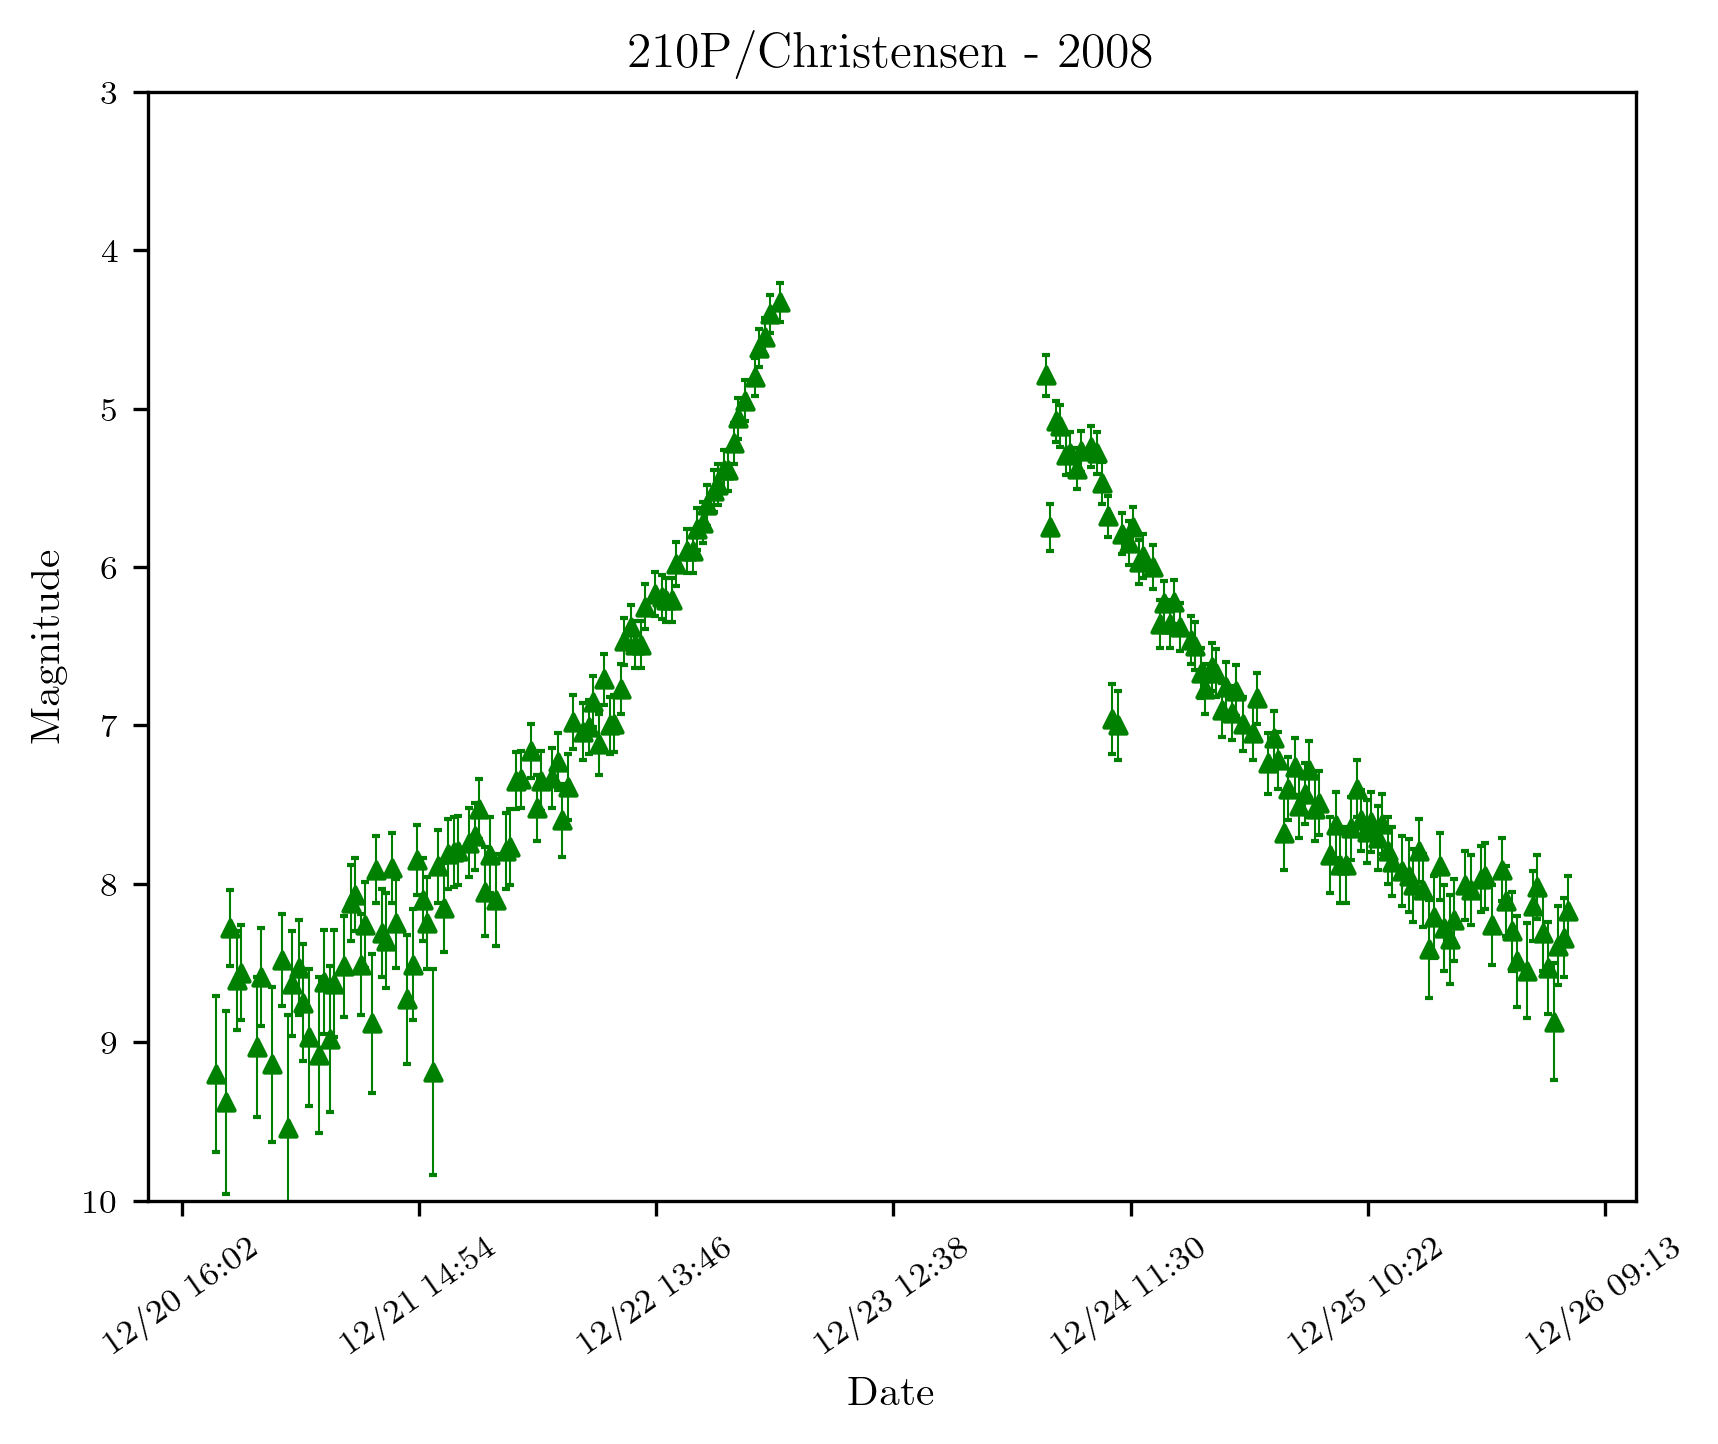

In [9]:
# Here we combine the pd objects df1 and df2 into one new object df3 so that we can plot all the data on the same graph

# Select relevant columns from df1 and df2
df1_selected = df1[['DateTime', 'Magnitude']]
if ERROR_COLUMN:
    df2_selected = df2[['DateTime', column_to_plot, ERROR_COLUMN]]
else:
    df2_selected = df2[['DateTime', column_to_plot]]


# Combine the columns from the two data file into a new thrid data object
df3 = pd.concat([df1_selected, df2_selected], ignore_index=True)

# Format the date strings for df3 in MM/DD format
if SOHO_ONLY:
    date_labels_df3 = df3['DateTime'].dt.strftime('%m/%d %H:%M')
else:
    date_labels_df3 = df3['DateTime'].dt.strftime('%m/%d')

# Calculate the range of dates in the df3 dataset to scale X-Axis
date_range = df3['DateTime'].max() - df3['DateTime'].min()

# Calculate the step size for each tick on the X-Axis based on XSTEPS
step_size = date_range / (XSTEPS - 1)

# Generate the tick positions for the X-Axis
tick_positions = [df3['DateTime'].min() + step_size * i for i in range(XSTEPS)]

# Generate the tick labels for the X-Axis
if SOHO_ONLY:
    tick_labels = [date.strftime('%m/%d %H:%M') for date in tick_positions]
else:
    tick_labels = [date.strftime('%m/%d') for date in tick_positions]


# Set the x-axis ticks and labels
plt.xticks(tick_positions, tick_labels, rotation=XROT)

# Set the y-axis limits manually
plt.ylim(MIN_MAG, MAX_MAG)  # Adjust the limits as needed in the variable section

# Scatter plot for df3, specifying marker and color for each dataset
if SOHO_ONLY:
    scatter = plt.scatter(df3['DateTime'], df3[column_to_plot], label=DF2_LABEL, s=15, edgecolor='green', marker='^', facecolor='green')
    if ERROR_COLUMN:
        plt.errorbar(df3['DateTime'], df3[column_to_plot], yerr=df3[ERROR_COLUMN], fmt='none', ecolor='green', capsize=1, linewidth=0.5)
else:
    plt.scatter(df3['DateTime'], df3['Magnitude'], label=DF1_LABEL, s=10, edgecolor='red', marker='o', facecolor='none')
    scatter = plt.scatter(df3['DateTime'], df3[column_to_plot], label=DF2_LABEL, s=15, edgecolor='green', marker='^', facecolor='green')
    if ERROR_COLUMN:
        plt.errorbar(df3['DateTime'], df3[column_to_plot], yerr=df3[ERROR_COLUMN], fmt='none', ecolor='green', capsize=1, linewidth=0.5)

# Add labels for the x and y axes
plt.xlabel(XLABEL)
plt.ylabel(YLABEL)

# Add title
plot_title = COMET + ' - ' + YEAR
plt.title(plot_title)

# Change the font size of tick labels
plt.xticks(fontsize=8)  # Adjust the font size as needed
plt.yticks(fontsize=8)  # Adjust the font size as needed

# Invert the Y-axis so smaller numbers represent brighter magnitudes
plt.gca().invert_yaxis()

#Create the legend and allow python to put it in the most reasonable place
if DF2_LABEL:
    plt.legend()

# Draw the plot
#plt.show()

# Save the plot; rename to desired filename
if ERROR_COLUMN:
    filename_base = YEAR + '_' + COMET.replace(" ", "") + '-ERR' + '.png'
else:
    filename_base = YEAR + '_' + COMET.replace(" ", "") + '.png'
if SOHO_ONLY:
    filename = 'SOHO_' + filename_base
else:
    filename ='MPC_SOHO_' + filename_base

filename = filename.replace("/", "_")
plt.savefig(filename)
